In [1]:
import pandas as pd
import json
from sqlalchemy import create_engine
import psycopg2
from mplsoccer import VerticalPitch,Pitch
from matplotlib import pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 100)

import os

In [2]:
#all_events = pd.read_csv('Manchester United Events 2023-2024 Preprocessed.csv',index_col=0)
all_events = pd.read_csv('Lille Events 2023-2024 Preprocessed.csv',index_col=0)
all_events.head()

C:\Users\MSI\AppData\Local\Temp\ipykernel_16696\4034137448.py:2: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  all_events = pd.read_csv('Lille Events 2023-2024 Preprocessed.csv',index_col=0)


,id,event_id,minute,second,team_id,x,y,expanded_minute,satisfied_events_types,is_touch,period_value,period_display_name,type_value,type_display_name,outcome_type_value,outcome_type_display_name,player_id,end_x,end_y,blocked_x,blocked_y,goal_mouth_z,goal_mouth_y,is_shot,related_event_id,related_player_id,card_type_value,cardType.displayName,is_goal,match_id,is_own_goal,player_name,BlockedCross,HeadPass,ParriedSafe,OppositeRelatedEvent,IndividualPlay,PassEndX,PassEndY,DivingSave,GoalMouthY,Cross,HighLeft,SmallBoxLeft,OutOfBoxRight,OutOfBoxCentre,ThrowinSetPiece,KeeperSaveObox,PlayerCaughtOffside,FormationSlot,Volley,Longball,FirstTouch,GoalMouthZ,IntentionalGoalAssist,Red,BigChanceCreated,SetPiece,BlockedX,Length,VoidYellowCard,Obstruction,BoxLeft,ParriedDanger,StandingSave,PlayerPosition,DeepBoxRight,Foul,MissLeft,Head,ShotAssist,SixYardBlock,LeftFoot,Assisted,OneOnOne,MissHigh,BoxRight,RegularPlay,JerseyNumber,Yellow,MissRight,GoalDisallowed,KeeperSaveInSixYard,Offensive,Zone,BoxCentre,Throughball,OutfielderBlock,CaptainPlayerId,Blocked,TeamPlayerFormation,RightFoot,Hands,FromCorner,OutOfBoxDeepRight,Angle,FastBreak,OtherBodyPart,IndirectFreekickTaken,Feet,OutOfBoxDeepLeft,LeadingToAttempt,GoalKick,BigChance,InvolvedPlayers,LastMan,BlockedY,Defensive,HighCentre,Penalty,Collected,LowRight,DeepBoxLeft,Chipped,LowCentre,SmallBoxCentre,KeeperSaved,KeyPass,LowLeft,SmallBoxRight,RelatedEventId,ThrowIn,SavedOffline,IntentionalAssist,OwnGoal,CornerTaken,OverRun,LayOff,ThirtyFivePlusCentre,KeeperThrow,HighClaim,HighRight,KeeperMissed,KeeperSaveInTheBox,TeamFormation,DirectFreekick,AerialFoul,SecondYellow,FreekickTaken,LeadingToGoal,pass_recipient_name,pass_recipient_id
0,2.579628e+09,2,0,0.0,607,0.0,0.0,0,[],False,1,FirstHalf,32,Start,1,Successful,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.579628e+09,3,0,0.0,607,50.0,50.0,0,"[91, 117, 30, 35, 38, 215, 218]",True,1,FirstHalf,1,Pass,1,Successful,85693.0,32.5,44.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Rémy Cabella,NaN,NaN,NaN,NaN,NaN,32.5,44.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Back,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bafodé Diakité,366875.0
2,2.579628e+09,4,0,2.0,607,36.5,49.7,0,"[91, 120, 124, 128, 36, 37, 217, 218]",True,1,FirstHalf,1,Pass,0,Unsuccessful,366875.0,71.7,88.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Bafodé Diakité,NaN,NaN,NaN,NaN,NaN,71.7,88.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Left,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.579628e+09,6,0,10.0,607,71.3,100.0,0,"[91, 212, 35, 38, 216]",True,1,FirstHalf,1,Pass,1,Successful,81662.0,55.0,92.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Ismaily,NaN,NaN,NaN,NaN,NaN,55.0,92.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Left,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.50,Na

In [3]:
player_list = all_events[['player_name','player_id']]
player_list = player_list.drop_duplicates().dropna().reset_index(drop=True)
player_list

,player_name,player_id
0,Rémy Cabella,85693.0
1,Bafodé Diakité,366875.0
2,Ismaily,81662.0
3,Alexsandro Ribeiro,438897.0
4,Edon Zhegrova,363181.0
5,Tiago Santos,447025.0
6,Angel Gomes,338497.0
7,Benjamin André,43415.0
8,Lucas Chevalier,398299.0
9,Hákon Haraldsson,424252.0


In [4]:
all_events.type_display_name.unique()

array(['Start', 'Pass', 'TakeOn', 'BallTouch', 'Aerial', 'Interception',
       'BallRecovery', 'Foul', 'Tackle', 'CornerAwarded', 'Challenge',
       'Clearance', 'Punch', 'Save', 'Dispossessed', 'SavedShot',
       'MissedShots', 'OffsideProvoked', 'BlockedPass', 'Smother',
       'KeeperPickup', 'ShotOnPost', 'End', 'Goal', 'SubstitutionOff',
       'SubstitutionOn', 'FormationChange', 'Card', 'FormationSet',
       'Error', 'KeeperSweeper', 'GoodSkill', 'ShieldBallOpp', 'Claim',
       'OffsideGiven', 'OffsidePass', 'PenaltyFaced'], dtype=object)

In [6]:
playerName='Leny Yoro'

In [28]:
# Check event type
defensive_events = all_events.loc[(all_events.player_name==f'{playerName}')&
                       (all_events.type_display_name.isin(['Clearance','Aerial','Interception','Tackle','BallRecovery']))].reset_index(drop=True)
defensive_events[['type_display_name','outcome_type_display_name']].head(10)

,type_display_name,outcome_type_display_name
0,Tackle,Successful
1,Clearance,Successful
2,Clearance,Successful
3,Aerial,Unsuccessful
4,Aerial,Unsuccessful
5,BallRecovery,Successful
6,Aerial,Unsuccessful
7,Aerial,Successful
8,Aerial,Unsuccessful
9,Aerial,Successful


In [29]:
defensive_events.outcome_type_display_name.unique()

array(['Successful', 'Unsuccessful'], dtype=object)

# Addition
- Add Clearance Plot
- Add Aerial Plot
- Add Interception Plot
- Add Ball Recovery Plot
- Add Tackle Plot
- Check if merged to defensive actions


In [33]:
clearance_events = all_events.loc[(all_events.player_name==f'{playerName}')&(all_events.type_display_name=='Clearance')].reset_index(drop=True)
interception_events = all_events.loc[(all_events.player_name==f'{playerName}')&(all_events.type_display_name=='Interception')].reset_index(drop=True)
tackle_events = all_events.loc[(all_events.player_name==f'{playerName}')&(all_events.type_display_name=='Tackle')].reset_index(drop=True)
aerial_events = all_events.loc[(all_events.player_name==f'{playerName}')&(all_events.type_display_name=='Aerial')].reset_index(drop=True)
recovery_events = all_events.loc[(all_events.player_name==f'{playerName}')&(all_events.type_display_name=='BallRecovery')].reset_index(drop=True)
take_on_events = all_events.loc[(all_events.player_name==f'{playerName}')&(all_events.type_display_name=='TakeOn')].reset_index(drop=True)
passing = all_events.loc[(all_events.player_name==f'{playerName}')&(all_events.type_display_name=='Pass')].reset_index(drop=True)
receive_pass = all_events.loc[all_events.pass_recipient_name==f'{playerName}'].reset_index(drop=True)
player_events = all_events.loc[all_events.player_name==f'{playerName}'].reset_index(drop=True)

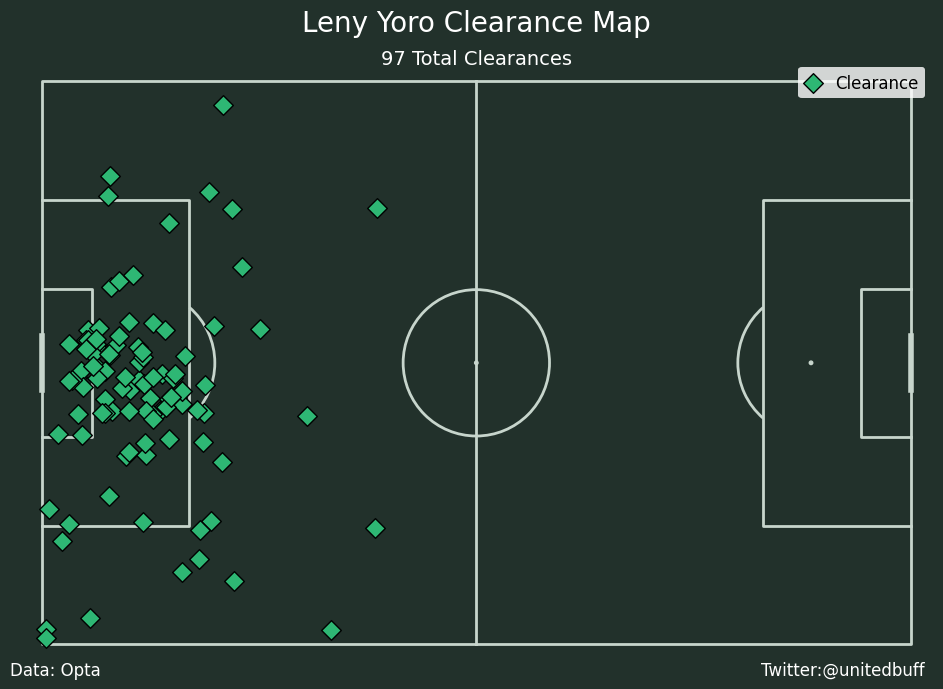

In [123]:
def plot_clearance_map(playerName):
    clearance_success = clearance_events.loc[clearance_events.outcome_type_display_name=='Successful']
    clearance_success_count = len(clearance_success.index)
    
    pitch = Pitch(pitch_type='opta', half=False, line_zorder=2,pitch_color='#22312b', line_color='#c7d5cc')
    fig, ax = pitch.draw(figsize=(12, 7))
    fig.set_facecolor('#22312b')

    pitch.scatter(clearance_success.x, clearance_success.y, s=100,marker='D', c = '#2eb774', zorder=3, ax=ax,edgecolors="black",label='Clearance')

    # Set up the legend
    ax.legend(facecolor='white', handlelength=1, edgecolor='None', fontsize=12, loc='upper right')

    # Set the title
    ax_title = ax.set_title(f'{playerName} Clearance Map', fontsize=20,color='white', pad=20)
    ax.text(0.5, 1, f'{clearance_success_count} Total Clearances', ha='center', va='center', transform=ax.transAxes, fontsize=14, color='white')
    ax.text(-.01, -.02, 'Data: Opta', ha='left', va='bottom', transform=ax.transAxes, fontdict={'size':12, 'color':'white'})
    ax.text(.99, -.02, 'Twitter:@unitedbuff', ha='right', va='bottom', transform=ax.transAxes, fontdict={'size':12, 'color':'white'}) 
plot_clearance_map(playerName)

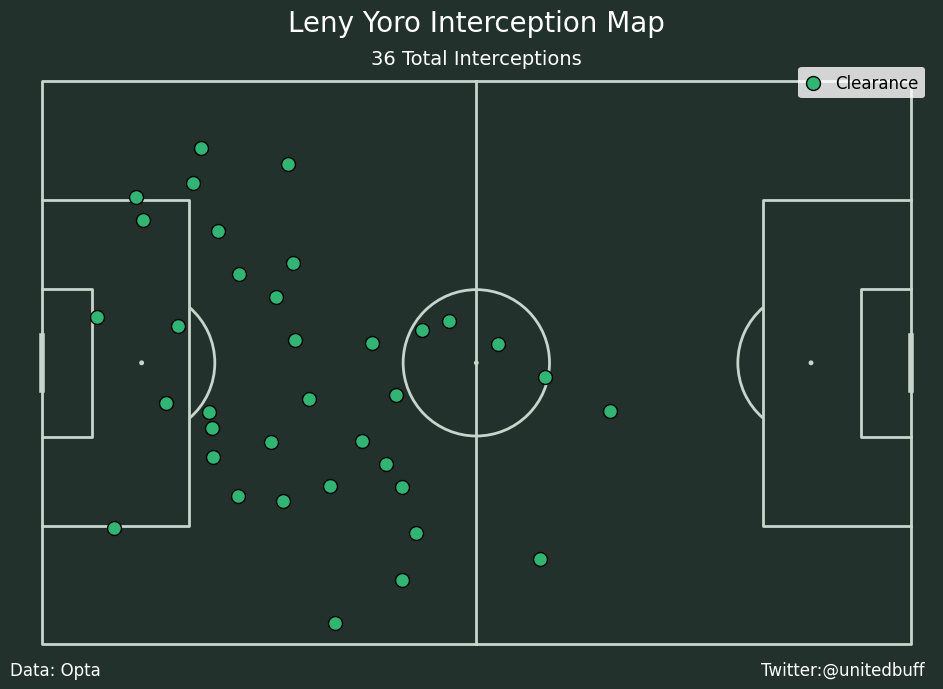

In [126]:
def plot_interception_map(playerName):
    interception_success = interception_events.loc[interception_events.outcome_type_display_name=='Successful']
    interception_success_count = len(interception_success.index)
    
    pitch = Pitch(pitch_type='opta', half=False, line_zorder=2,pitch_color='#22312b', line_color='#c7d5cc')
    fig, ax = pitch.draw(figsize=(12, 7))
    fig.set_facecolor('#22312b')

    pitch.scatter(interception_success.x, interception_success.y, s=100,marker='o', c = '#2eb774', zorder=3, ax=ax,edgecolors="black",label='Clearance')

    # Set up the legend
    ax.legend(facecolor='white', handlelength=1, edgecolor='None', fontsize=12, loc='upper right')

    # Set the title
    ax_title = ax.set_title(f'{playerName} Interception Map', fontsize=20,color='white', pad=20)
    ax.text(0.5, 1, f'{interception_success_count} Total Interceptions', ha='center', va='center', transform=ax.transAxes, fontsize=14, color='white')
    ax.text(-.01, -.02, 'Data: Opta', ha='left', va='bottom', transform=ax.transAxes, fontdict={'size':12, 'color':'white'})
    ax.text(.99, -.02, 'Twitter:@unitedbuff', ha='right', va='bottom', transform=ax.transAxes, fontdict={'size':12, 'color':'white'}) 
plot_interception_map(playerName)

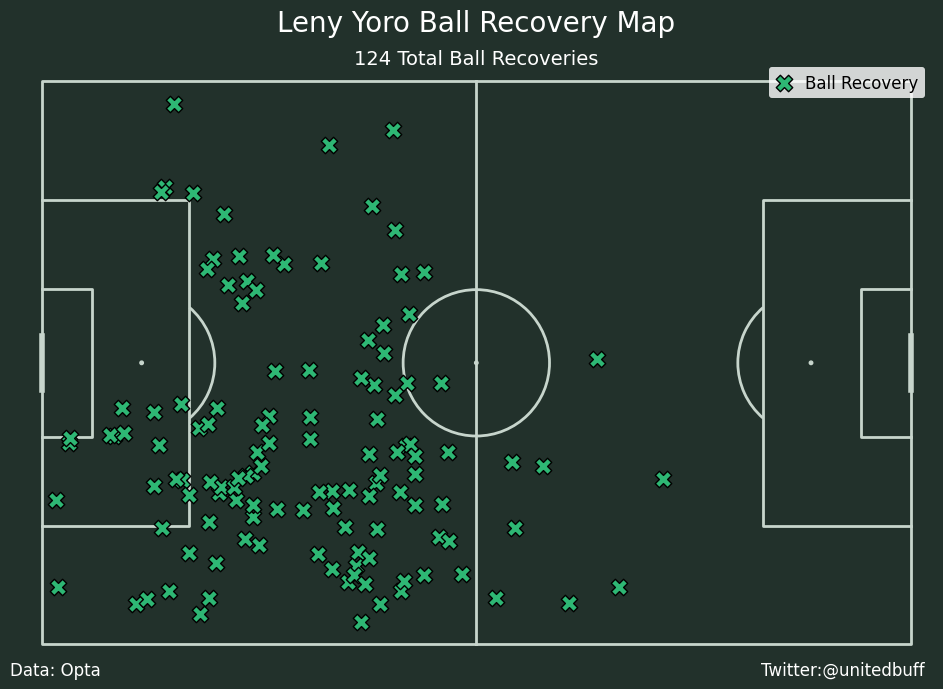

In [122]:
def plot_recovery_map(playerName):
    # Recovery
    recovery_success = recovery_events.loc[recovery_events.outcome_type_display_name=='Successful']
    recovery_success_count = len(recovery_success.index)
    
    # Draw the Pitch
    pitch = Pitch(pitch_type='opta', half=False, line_zorder=2,pitch_color='#22312b', line_color='#c7d5cc')
    fig, ax = pitch.draw(figsize=(12, 7))
    fig.set_facecolor('#22312b')

    pitch.scatter(recovery_success.x, recovery_success.y, s=140,marker='X', c = '#2eb774', zorder=3, ax=ax,edgecolors="black",label='Ball Recovery')
    # Set up the legend
    ax.legend(facecolor='white', handlelength=1, edgecolor='None', fontsize=12, loc='upper right')

    # Set the title
    ax_title = ax.set_title(f'{playerName} Ball Recovery Map', fontsize=20,color='white', pad=20)
    ax.text(0.5, 1, f'{recovery_success_count} Total Ball Recoveries', ha='center', va='center', transform=ax.transAxes, fontsize=14, color='white')
    ax.text(-.01, -.02, 'Data: Opta', ha='left', va='bottom', transform=ax.transAxes, fontdict={'size':12, 'color':'white'})
    ax.text(.99, -.02, 'Twitter:@unitedbuff', ha='right', va='bottom', transform=ax.transAxes, fontdict={'size':12, 'color':'white'}) 
plot_recovery_map(playerName)

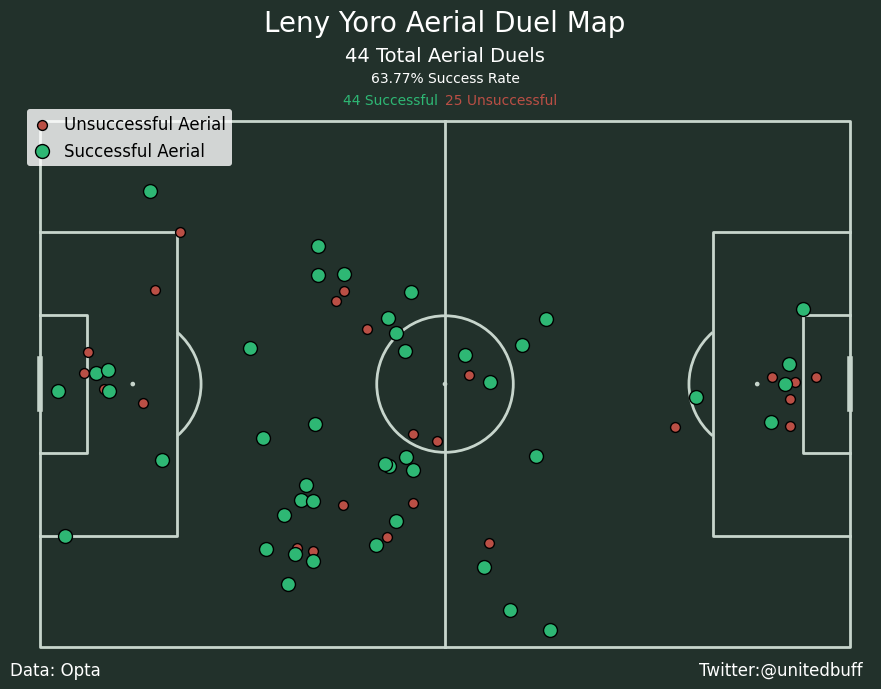

In [111]:
def plot_aerial_map(playerName):
    # Aerial
    aerial_success = aerial_events.loc[aerial_events.outcome_type_display_name=='Successful']
    aerial_fail = aerial_events.loc[aerial_events.outcome_type_display_name=='Unsuccessful']

    aerial_success_count = len(aerial_success.index)
    aerial_fail_count = len(aerial_fail.index)
    try:
        aerial_rate = round(aerial_success_count/(aerial_success_count + aerial_fail_count) *100,2)
    except ZeroDivisionError:
        aerial_rate = 0
    
    # Draw the Pitch
    pitch = Pitch(pitch_type='opta', half=False, line_zorder=2,pitch_color='#22312b', line_color='#c7d5cc')
    fig, ax = pitch.draw(figsize=(12, 7))
    fig.set_facecolor('#22312b')

    pitch.scatter(aerial_fail.x, aerial_fail.y, s=50,marker='o', c = '#ba4f45', zorder=3, ax=ax,edgecolors="black",label='Unsuccessful Aerial')
    pitch.scatter(aerial_success.x, aerial_success.y, s=100,marker='o', c = '#2eb774', zorder=3, ax=ax,edgecolors="black",label='Successful Aerial')
    
    # Set up the legend
    ax.legend(facecolor='white', handlelength=1, edgecolor='None', fontsize=12, loc='upper left')

    # Set the title
    ax_title = ax.set_title(f'{playerName} Aerial Duel Map', fontsize=20,color='white', pad=50)
    ax.text(0.5, 1.08, f'{aerial_success_count} Total Aerial Duels', ha='center', va='center', transform=ax.transAxes, fontsize=14, color='white')
    ax.text(0.5, 1.04, f'{aerial_rate}% Success Rate', ha='center', va='center', transform=ax.transAxes, fontsize=10, color='white')
    ax.text(0.38, 1, f'{aerial_success_count} Successful', ha='left', va='center', transform=ax.transAxes, fontsize=10, color='#2eb774')
    ax.text(0.5, 1, f'{aerial_fail_count} Unsuccessful', ha='left', va='center', transform=ax.transAxes, fontsize=10, color='#ba4f45')
    ax.text(-.01, -.02, 'Data: Opta', ha='left', va='bottom', transform=ax.transAxes, fontdict={'size':12, 'color':'white'})
    ax.text(.99, -.02, 'Twitter:@unitedbuff', ha='right', va='bottom', transform=ax.transAxes, fontdict={'size':12, 'color':'white'}) 
plot_aerial_map(playerName)

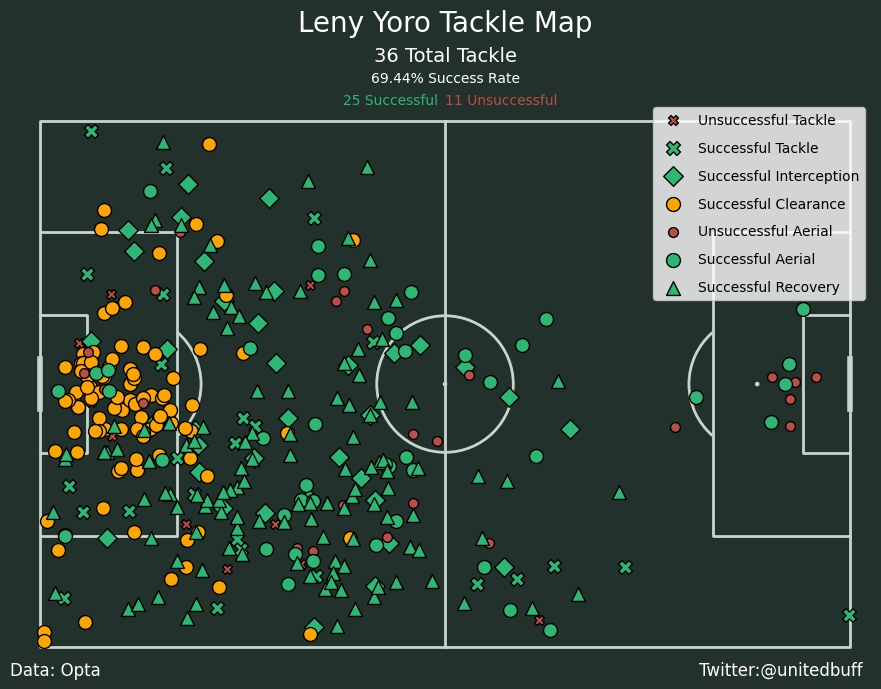

In [70]:
def plot_defensive_map(playerName):
    # Tackle
    tackle_success = tackle_events.loc[tackle_events.outcome_type_display_name=='Successful']
    tackle_fail = tackle_events.loc[tackle_events.outcome_type_display_name=='Unsuccessful']

    tackle_success_count = len(tackle_success.index)
    tackle_fail_count = len(tackle_fail.index)
    try:
        tackle_rate = round(tackle_success_count/(tackle_fail_count + tackle_success_count) *100,2)
    except ZeroDivisionError:
        tackle_rate = 0

    # Interception
    interception_success = interception_events.loc[interception_events.outcome_type_display_name=='Successful']
    interception_fail = interception_events.loc[interception_events.outcome_type_display_name=='Unsuccessful']

    interception_success_count = len(interception_success.index)
    interception_fail_count = len(interception_fail.index)
    try:
        interception_rate = round(interception_success_count/(interception_fail_count + interception_success_count) *100,2)
    except ZeroDivisionError:
        interception_rate = 0

    

    # Aerial
    aerial_success = aerial_events.loc[aerial_events.outcome_type_display_name=='Successful']
    aerial_fail = aerial_events.loc[aerial_events.outcome_type_display_name=='Unsuccessful']

    aerial_success_count = len(aerial_success.index)
    aerial_fail_count = len(aerial_fail.index)
    try:
        aerial_rate = round(aerial_success_count/(aerial_success_count + aerial_fail_count) *100,2)
    except ZeroDivisionError:
        aerial_rate = 0
    
    # Recovery
    recovery_success = recovery_events.loc[recovery_events.outcome_type_display_name=='Successful']
    recovery_fail = recovery_events.loc[recovery_events.outcome_type_display_name=='Unsuccessful']

    recovery_success_count = len(recovery_success.index)
    recovery_fail_count = len(recovery_fail.index)
    try:
        recovery_rate = round(recovery_success_count/(recovery_success_count + recovery_fail_count) *100,2)
    except ZeroDivisionError:
        recovery_rate = 0
    
    #Draw the pitch
    pitch = Pitch(pitch_type='opta', half=False, line_zorder=2,pitch_color='#22312b', line_color='#c7d5cc')
    fig, ax = pitch.draw(figsize=(12, 7))
    fig.set_facecolor('#22312b')

    pitch.scatter(tackle_fail.x, tackle_fail.y, s=50, marker='X', c = '#ba4f45', zorder=3, ax=ax,edgecolors="black",label='Unsuccessful Tackle')
    pitch.scatter(tackle_success.x, tackle_success.y, s=100,marker='X', c = '#2eb774', zorder=3, ax=ax,edgecolors="black",label='Successful Tackle')
    #pitch.scatter(interception_fail.x, interception_fail.y, s=50,marker='d', c = '#ba4f45', zorder=3, ax=ax,edgecolors="black")
    pitch.scatter(interception_success.x, interception_success.y, s=100,marker='D', c = '#2eb774', zorder=3, ax=ax,edgecolors="black",label='Successful Interception')
    #pitch.scatter(clearance_fail.x, clearance_fail.y, s=50, marker='s', c = '#ba4f45', zorder=3, ax=ax,edgecolors="black",label='Unsuccessful Clearance')
    pitch.scatter(clearance_success.x, clearance_success.y, s=100,marker='o', c = 'orange', zorder=3, ax=ax,edgecolors="black",label='Successful Clearance')
    pitch.scatter(aerial_fail.x, aerial_fail.y, s=50,marker='o', c = '#ba4f45', zorder=3, ax=ax,edgecolors="black",label='Unsuccessful Aerial')
    pitch.scatter(aerial_success.x, aerial_success.y, s=100,marker='o', c = '#2eb774', zorder=3, ax=ax,edgecolors="black",label='Successful Aerial')
    pitch.scatter(recovery_fail.x, recovery_fail.y, s=50,marker='^', c = '#ba4f45', zorder=3, ax=ax,edgecolors="black")
    pitch.scatter(recovery_success.x, recovery_success.y, s=100,marker='^', c = '#2eb774', zorder=3, ax=ax,edgecolors="black",label='Successful Recovery')
    # Set up the legend
    ax.legend(labelspacing=1,loc='upper right')

    # Set the title
    ax_title = ax.set_title(f'{playerName} Tackle Map', fontsize=20,color='white', pad=50)
    ax.text(0.5, 1.08, f'{tackle_success_count + tackle_fail_count} Total Tackle', ha='center', va='center', transform=ax.transAxes, fontsize=14, color='white')
    ax.text(0.5, 1.04, f'{tackle_rate}% Success Rate', ha='center', va='center', transform=ax.transAxes, fontsize=10, color='white')
    ax.text(0.38, 1, f'{tackle_success_count} Successful', ha='left', va='center', transform=ax.transAxes, fontsize=10, color='#2eb774')
    ax.text(0.5, 1, f'{tackle_fail_count} Unsuccessful', ha='left', va='center', transform=ax.transAxes, fontsize=10, color='#ba4f45')
    ax.text(-.01, -.02, 'Data: Opta', ha='left', va='bottom', transform=ax.transAxes, fontdict={'size':12, 'color':'white'})
    ax.text(.99, -.02, 'Twitter:@unitedbuff', ha='right', va='bottom', transform=ax.transAxes, fontdict={'size':12, 'color':'white'}) 
plot_defensive_map(playerName)